In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import svm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import seaborn as sns


In [2]:
# Define the date range and ticker
start_date = '2010-01-01'
end_date = '2024-05-13'
ticker = 'EURUSD=X'  # Yahoo Finance ticker for EUR/USD exchange rate

In [3]:
# Download the EUR/USD exchange rate data
data = yf.download(ticker, start=start_date, end=end_date)
data.head(2)


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-01,1.432706,1.440196,1.432706,1.438994,1.438994,0
2010-01-04,1.431004,1.445191,1.426208,1.442398,1.442398,0


In [4]:
# Remove missing values
data.dropna(inplace=True)


In [5]:
# Calculate daily returns of EUR/USD exchange rate
data['Return'] = data['Close'].pct_change()

In [6]:
# Remove the first row with NaN return
data.dropna(subset=['Return'], inplace=True)


In [7]:
# Fetch Federal Reserve interest rate data
fed_data = yf.download("^IRX", start=start_date, end=end_date)


[*********************100%%**********************]  1 of 1 completed


In [8]:
fed_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,0.080,0.080,0.055,0.055,0.055,0
2010-01-05,0.060,0.065,0.040,0.060,0.060,0
2010-01-06,0.060,0.060,0.045,0.045,0.045,0
2010-01-07,0.045,0.055,0.040,0.045,0.045,0
2010-01-08,0.045,0.045,0.035,0.040,0.040,0
...,...,...,...,...,...,...
2024-05-06,5.238,5.243,5.235,5.240,5.240,0
2024-05-07,5.240,5.243,5.240,5.243,5.243,0
2024-05-08,5.245,5.245,5.245,5.245,5.245,0


In [9]:
# Merge EUR/USD data with Federal Reserve data
new_data = data.merge(fed_data['Adj Close'], how='left', left_index=True, right_index=True)
new_data.rename(columns={'Adj Close_y': 'Fed Rate'}, inplace=True)


In [10]:
# Remove missing values again
new_data.dropna(inplace=True)


In [11]:
# Check column names before dropping columns
print(new_data.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close_x', 'Volume', 'Return',
       'Fed Rate'],
      dtype='object')


In [12]:
# Drop the columns not used for modeling
# Ensure only the intended columns are dropped
columns_to_drop = ['Adj Close', 'Close'] if 'Adj Close' in new_data.columns else ['Close']
new_data.drop(columns_to_drop, axis=1, inplace=True)


In [13]:
# Check the dataframe after dropping columns
new_data.head()

,Open,High,Low,Adj Close_x,Volume,Return,Fed Rate
Date,,,,,,,
2010-01-04,1.431004,1.445191,1.426208,1.442398,0,0.002366,0.055
2010-01-05,1.442710,1.448310,1.435194,1.436596,0,-0.004022,0.060
2010-01-06,1.436596,1.443460,1.429123,1.440403,0,0.002650,0.045
2010-01-07,1.440300,1.444481,1.430206,1.431803,0,-0.005971,0.045
2010-01-08,1.432090,1.443606,1.427104,1.441109,0,0.006499,0.040


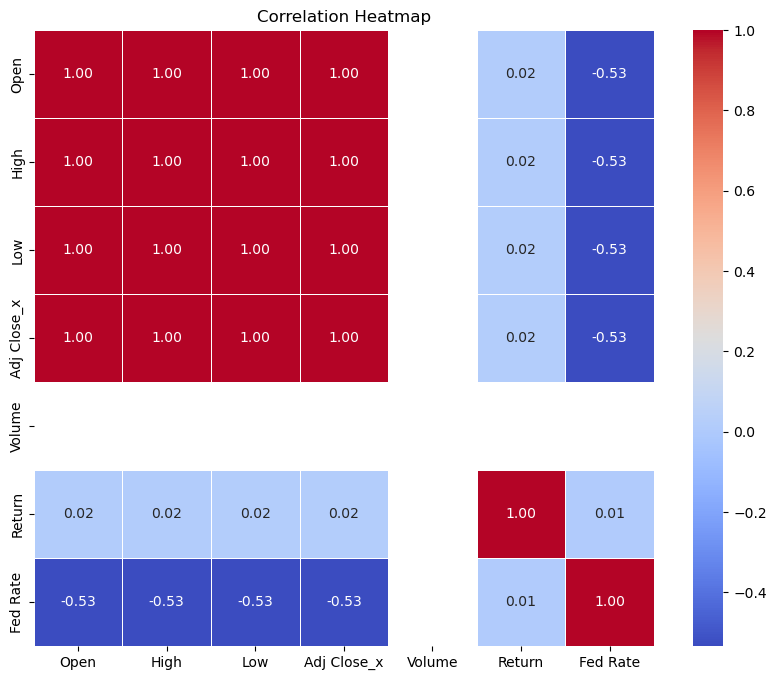

In [14]:
# Calculate the correlation matrix
corr = new_data.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [15]:
new_data['Volume'].sum()

0

In [16]:
# Split the data into training and testing sets
X = new_data.drop(columns=['Return', 'Volume'])
y = new_data['Return']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
X_train

,Open,High,Low,Adj Close_x,Fed Rate
Date,,,,,
2015-03-27,1.088554,1.089538,1.080530,1.088637,0.030
2019-11-13,1.101212,1.102050,1.100110,1.101237,1.535
2021-07-12,1.187366,1.188213,1.183670,1.187296,0.043
2013-02-27,1.306933,1.312612,1.304291,1.306592,0.100
2019-02-07,1.136635,1.137010,1.132605,1.136596,2.355
...,...,...,...,...,...
2014-07-07,1.358954,1.360700,1.357731,1.358843,0.007
2015-03-02,1.117094,1.124040,1.116395,1.116196,0.005
2013-06-07,1.324381,1.327510,1.319470,1.324556,0.040


In [18]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# Set the parameters for grid search
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [1, 10, 100],
    'gamma': ['scale', 'auto'],  # 'gamma' is only relevant for 'rbf', 'poly', and 'sigmoid'
    'epsilon': [0.01, 0.1, 1]
}

In [20]:
# Create a GridSearchCV object
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_svr = grid_search.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [21]:
best_svr

SVR(C=100, epsilon=0.01, gamma='auto', kernel='poly')

In [22]:
# Predict on the test set
y_pred = best_svr.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Test MSE: {mse}")
print(f"Test R2 Score: {r2}")

Best Parameters: {'C': 100, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'}
Test MSE: 2.752230846364795e-05
Test R2 Score: 0.08707652541523514
